In [1]:
from __future__ import print_function
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
import mshr

The mesh provided by the class **mshr** and its method *generate_mesh* automatically produces periodic mesh. This can be justified by examining the nodes of boundaries and easily seen for the simple case of UnitSquareMesh. Therefore, we will use the class **mshr** for our mesh generation and do not need to rely on the **gmsh** at this point.

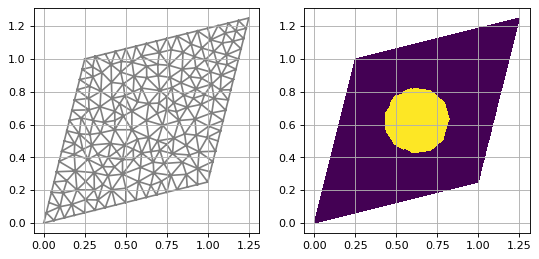

In [2]:
# Create domain, mark subdomains and generate mesh
domain = mshr.Polygon([Point(0, 0), Point(1, 0.25), Point(1.25, 1.25), Point(0.25, 1)])
inclusion = mshr.Circle(Point(1.25/2, 1.25/2), 0.2)
domain.set_subdomain(1, inclusion)

mesh = mshr.generate_mesh(domain, 12)
subdomain_marker = MeshFunction('size_t', mesh, mesh.topology().dim(),
                               mesh.domains())

plt.figure(figsize=(8, 4), dpi = 80)
plt.subplot(1,2,1)
plot(mesh); plt.grid()
plt.subplot(1,2,2)
plot(subdomain_marker); plt.grid()

In [3]:
a = z[0,:] = [10, 1]
print(z)

NameError: name 'z' is not defined

In [ ]:
np.allclose(np.array([0, 1]), np.array([1, 1]), 2)

In [ ]:
# classed used to define the periodic boundary map
class PeriodicBoundary(SubDomain):
    # Constructor
    def __ini__(self, vertices, TOL=DOLFIN_EPS_LARGE):
        # verticies stores the coordinates of the 4 unit cell corners
        super().__init__()
        self.TOL = TOL
        self.vertices = vertices
        # vectors generating periodicity
        self.a = np.zeros((2, 2))
        self.a[0,:] = vertices[1,:] - vertices[0,:]
        self.a[1,:] = vertices[3,:] - vertices[0,:]
        
        # vectors normal to vectors a[0,:] and a[1,:]
        self.n = np.zeros((2,2))
        self.n[0,:] = [ -self.a[0,1], self.a[0,0] ]
        self.n[1,:] = [ -self.a[1,1], self.a[1,0] ]
        
        assert np.dot(self.n[0,:], self.a[0,:]) < self.TOL
        assert np.dot(self.n[1,:], self.a[1,:]) < self.TOL
        
    # method "inside" overide the superclass method
    def inside(self, x, on_boundary):
        # return True if x is on the left or bottom boundaries
        # AND NOT on one of the bottom-right or top-left vertices
        top_left = np.allclose(x, self.vertices[3,:], self.TOL)
        bottom_right = np.allclose(x, self.vertices[1,:], self.TOL)
        bottom = np.dot(self.n[0,:], x - vertices[0,:]) < self.TOL
        
    

We now define the constitutive law for both phases. We employ the energy density for linear isotropic elasicity
\begin{equation}
    \psi = \frac{1}{2}\lambda \mathrm{trace}(\boldsymbol{\epsilon})^2 + \mu \mathrm{trace}(\boldsymbol{\epsilon}^2).
\end{equation}
The Lame parameters $\lambda$ and $\mu$ are computed in terms of the Young's modulus and Poisson ratio as follows:
\begin{equation}
    \lambda = \frac{E \nu}{(1 + \nu) (1 - 2\nu}, \quad \mu = \frac{E}{2(1 + \nu)}.
\end{equation}
Since both $\lambda$ and $\mu$

The stress tensor $\boldsymbol{\sigma}$ is derived as
\begin{equation}
    \boldsymbol{\sigma} = \lambda \mathrm{trace}(\boldsymbol{\epsilon})\mathbf{I} + 2\mu \boldsymbol{\epsilon}
\end{equation}
The tangent stiffness, which is linear in this case, is given by
\begin{equation}
    C_{ijkl} = \lambda \delta_{ij}\delta_{kl} + \mu(\delta_{il}\delta_{jk} + \delta_{ik}\delta_{jl})
\end{equation}
Due to the symmetries of the $\boldsymbol{\delta}$, the stiffness is (1) majorly symmetric: $C_{ijkl} = C_{klij}$ and (2) minorly symmetric: $C_{ijkl} = C_{jikl} = C_{ijlk}$.

In [ ]:
Em = 50e3
num = 0.2
Er = 210e3
nur = 0.3
material_parameters = [(Em, num), (Er, nur)]
nphases = len(material_parameters)
def eps(v):
    return sym(grad(v))
def sigma(v, i, Eps):
    E, nu = material_parameters[i]
    lmbda = E*nu/(1+nu)/(1-2*nu)
    mu = E/2/(1+nu)
    return lmbda*tr(eps(v) + Eps)*Identity(2) + 2*mu*(eps(v)+Eps)

## Variational formulation

The previous problem is very similar to a standard linear elasticity problem, except for the periodicity constraint which has now been included in the FunctionSpace definition and for the presence of an eigenstrain term $\boldsymbol{E}$. It can easily be shown that the variational formulation of the previous problem reads as: Find $\boldsymbol{v}\in V$ such that:

$$\begin{equation}
F(\boldsymbol{v},\widehat{\boldsymbol{v}}) = \int_{\mathcal{A}} (\boldsymbol{E}+\nabla^s\boldsymbol{v}):\mathbb{C}(\boldsymbol{y}):\nabla^s\widehat{\boldsymbol{v}}\text{ d} \Omega = 0 \quad \forall \widehat{\boldsymbol{v}}\in V
\end{equation}$$

The above problem is not well-posed because of the existence of rigid body translations. One way to circumvent this issue would be to fix one point but instead we will add an additional constraint of zero-average of the fluctuation field $v$ as is classically done in homogenization theory. This is done by considering an additional vectorial Lagrange multiplier $\lambda$ and considering the following variational problem (see the [pure Neumann boundary conditions FEniCS demo](https://fenicsproject.org/docs/dolfin/2019.1.0/python/demos/neumann-poisson/demo_neumann-poisson.py.html) for a similar formulation): Find $(\boldsymbol{v},\boldsymbol{\lambda})\in V\times \mathbb{R}^2$ such that:

$$\begin{equation}
\int_{\mathcal{A}} (\boldsymbol{E}+\nabla^s\boldsymbol{v}):\mathbb{C}(\boldsymbol{y}):\nabla^s\widehat{\boldsymbol{v}}\text{ d} \Omega + \int_{\mathcal{A}} \boldsymbol{\lambda}\cdot\widehat{\boldsymbol{v}} \text{ d} \Omega + \int_{\mathcal{A}} \widehat{\boldsymbol{\lambda}}\cdot\boldsymbol{v} \text{ d} \Omega = 0 \quad \forall (\widehat{\boldsymbol{v}}, \widehat{\boldsymbol{\lambda}})\in V\times\mathbb{R}^2
\end{equation}$$

Which can be summarized as:

$$\begin{equation}
a(\boldsymbol{v},\widehat{\boldsymbol{v}}) + b(\boldsymbol{\lambda},\widehat{\boldsymbol{v}}) + b(\widehat{\boldsymbol{\lambda}}, \boldsymbol{v}) = L(\widehat{\boldsymbol{v}}) \quad \forall (\widehat{\boldsymbol{v}}, \widehat{\boldsymbol{\lambda}})\in V\times\mathbb{R}^2
\end{equation}$$

This readily translates into the following FEniCS code:

In [ ]:
Ve = VectorElement("CG", mesh.ufl_cell(), 2)
Re = VectorElement("R", mesh.ufl_cell(), 0)
W = FunctionSpace(mesh, MixedElement([Ve, Re]), constrained_domain=PeriodicBoundary(vertices, tolerance=1e-10))
V = FunctionSpace(mesh, Ve)

v_,lamb_ = TestFunctions(W)
dv, dlamb = TrialFunctions(W)
w = Function(W)
dx = Measure('dx')(subdomain_data=subdomains)

We have used a general implementation using a sum over the different phases for the functional `F`. We then used the `lhs` and `rhs` functions to respectively extract the corresponding bilinear $a$ and linear $L$ forms.

## Resolution

The resolution of the auxiliary problem is performed for elementary load cases consisting of uniaxial strain and pure shear sollicitations by assigning unit values of the correspnonding $E_{ij}$ components. For each load case, the average stress $\boldsymbol{\Sigma}$ is computed components by components and the macroscopic stiffness components $\mathbb{C}^{hom}$ are then printed.

In [ ]:
def macro_strain(i):
    """returns the macroscopic strain for the 3 elementary load cases"""
    Eps_Voigt = np.zeros((3,))
    Eps_Voigt[i] = 1
    return np.array([[Eps_Voigt[0], Eps_Voigt[2]/2.], 
                    [Eps_Voigt[2]/2., Eps_Voigt[1]]])
def stress2Voigt(s):
    return as_vector([s[0,0], s[1,1], s[0,1]])

Chom = np.zeros((3, 3))
for (j, case) in enumerate(["Exx", "Eyy", "Exy"]):
    print("Solving {} case...".format(case))
    F = sum([inner(sigma(dv, i, Constant(macro_strain(j))), eps(v_))*dx(i) for i in range(nphases)]) + dot(lamb_,dv)*dx + dot(dlamb,v_)*dx
    a, L = lhs(F), rhs(F)
    solve(a == L, w, [])
    (v, lamb) = split(w)
    Sigma = np.zeros((3,))
    for k in range(3):
        Sigma[k] = assemble(sum([stress2Voigt(sigma(v, i, Eps))[k]*dx(i) for i in range(nphases)]))/vol
    Chom[j, :] = Sigma

print(np.array_str(Chom, precision=2))

In [ ]:
for (j, case) in enumerate(["Exx", "Eyy", "Exy"]):
    print("Solving {} case...".format(case))
    print(j)

It can first be verified that the obtained macroscopic stiffness is indeed symmetric and that the corresponding behaviour is quasi-isotropic (up to the finite element discretization error). Indeed, if $\lambda^{hom} = \mathbb{C}_{xxyy}$ and $\mu^{hom} = \mathbb{C}_{xyxy}$ we have that $\mathbb{C}_{xxxx}\approx\mathbb{C}_{yyyy}\approx \mathbb{C}_{xxyy}+2\mathbb{C}_{xyxy} = \lambda^{hom}+2\mu^{hom}$.

> **Note:** The macroscopic stiffness is not exactly symmetric because we computed it from the average stress which is not stricly verifying local equilibrium on the unit cell due to the FE discretization. A truly symmetric version can be obtained from the computation of the bilinear form for a pair of solutions to the elementary load cases.

In [ ]:
lmbda_hom = Chom[0, 1]
mu_hom = Chom[2, 2]
print(Chom[0, 0], lmbda_hom + 2*mu_hom)

We thus deduce that $E^{hom} = \mu^{hom}\dfrac{3\lambda^{hom}+2\mu^{hom}}{\lambda^{hom}+\mu^{hom}}$ and $\nu^{hom} = \dfrac{\lambda^{hom}}{2(\lambda^{hom}+\mu^{hom})}$ that is:

In [ ]:
E_hom = mu_hom*(3*lmbda_hom + 2*mu_hom)/(lmbda_hom + mu_hom)
nu_hom = lmbda_hom/(lmbda_hom + mu_hom)/2
print("Apparent Young modulus:", E_hom)
print("Apparent Poisson ratio:", nu_hom)

In [ ]:
# plotting deformed unit cell with total displacement u = Eps*y + v
y = SpatialCoordinate(mesh)
plt.figure()
p = plot(0.5*(dot(Eps, y)+v), mode="displacement", title=case)
plt.colorbar(p)
plt.show()